<a href="https://colab.research.google.com/github/salmanromeo/MAE_3403_Computer_Methods_in_Analysis_and_Design/blob/main/lecture_10_Paramater_Estimatation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Paramater Estimatation**

#####This code solves a parameter estimation inverse problem for the one-dimensional heat equation. The goal of this problem is to estimate the diffusion coefficient $D (=0.5)$ of the heat equation, given noisy observations of the solution at a certain time.
\begin{align}
  \frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial t^2}
    \end{align}

#####The main algorithm of the code is the Metropolis-Hastings Markov chain Monte Carlo (MCMC) algorithm, which estimates the unknown parameter $D$ given the observed data.
1. The MCMC algorithm is initialized with a guess for $D$ and the initial solution is computed.
2. The objective function (log-likelihood) is computed for the initial guess.
3. Then the algorithm loops over a certain number of iterations $(N)$ to update the guess and compute the new objective function.

At each iteration, the algorithm proposes a new guess for $D$ by adding a random perturbation to the current guess. The heat equation is then solved with the new guess and the log-likelihood is computed for the new solution. The algorithm then decides whether to accept the new guess or not based on the ratio of the new and the current log-likelihoods and a random number drawn from a uniform distribution. The accepted guess is stored and used as the current guess for the next iteration.

**Metropolis-Hastings Markov Chain Monte Carlo (MCMC) algorithm**

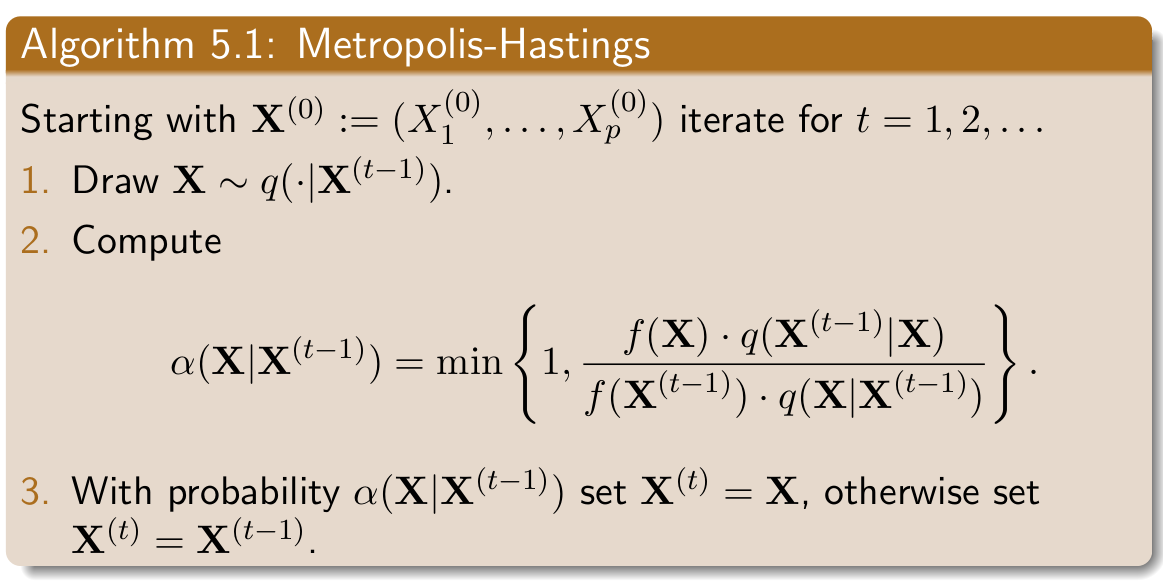

**One dimensional Heat Equation**

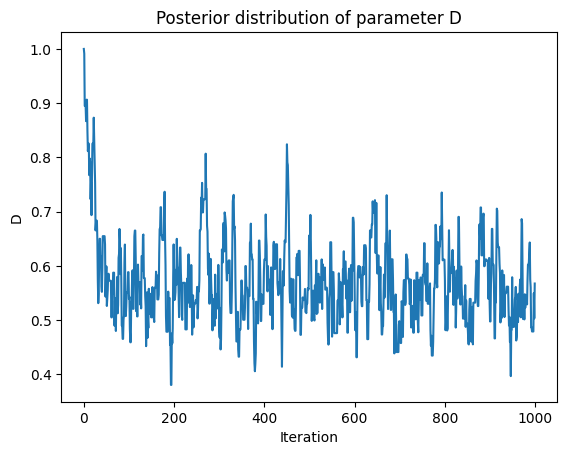

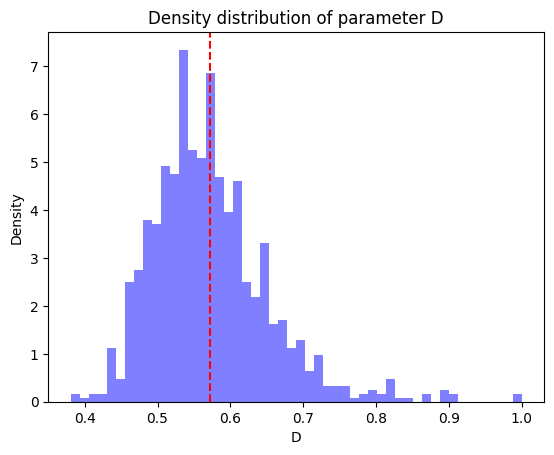

In [92]:
import numpy as np
import matplotlib.pyplot as plt

def heat(D, u0, q, tdim):
    xdim = len(u0)
    Z = np.zeros((tdim, xdim))
    Z[0, :] = u0
    for tin in range(1, tdim):
        tip = tin - 1
        Z[tin, 1:-1] = Z[tip, 1:-1] + \
            D*q*(Z[tip, :-2]-2*Z[tip, 1:-1]+Z[tip, 2:])
    return Z

# Problem parameters
L = 10
D = 0.5
s = 0.03
Tmax = 2
xdim = 25
tdim = 75

# Discretization
x = np.linspace(0, L, xdim)
t = np.linspace(0, Tmax, tdim)
dx = x[1]-x[0]
dt = t[1]-t[0]
q = dt/dx**2
r1 = 0.75*L
r2 = 0.8*L

# Initial condition
u0 = np.zeros(xdim)
u0[(x>=r1) & (x<=r2)] = 1
xDat = np.arange(1, xdim-1)
tDat = np.array([tdim-1])
nxDat = len(xDat)
ntDat = len(tDat)

# Solve the heat equation
Z = heat(D, u0, q, tdim)
u = Z[tDat[0], xDat]
uDat = u + s*np.random.randn(ntDat, nxDat)

# Metropolis-Hastings MCMC
N = 1000
m = 100
XD = 1
X = np.zeros(N)
X[0] = XD

Z = heat(XD, u0, q, tdim)
u = Z[tDat[0], xDat]
oLLkd = np.sum(-(u-uDat)**2)/(2*s**2)
LL = np.zeros(N)
LL[0] = oLLkd
w = 0.1

# Main loop
for n in range(1, N):
    XDp = XD + w*(2*np.random.rand()-1)
    if XDp > 0:
        Z = heat(XDp, u0, q, tdim)
        u = Z[tDat[0], xDat]
        nLLkd = np.sum(-(u-uDat)**2)/(2*s**2)
        alpha = np.exp(nLLkd - oLLkd)
        if np.random.rand() < alpha:
            XD = XDp
            oLLkd = nLLkd
            CZ = Z
    X[n] = XD
    LL[n] = oLLkd

# Plot the distribution of D
plt.figure()
plt.plot(X)
plt.xlabel("Iteration")
plt.ylabel("D")
plt.title("Posterior distribution of parameter D")
plt.show()

plt.figure()
plt.hist(X, bins=50, density=True, color="blue", alpha=0.5)
plt.axvline(np.mean(X), color="red", linestyle="--", label="Estimated parameter")
plt.xlabel("D")
plt.ylabel("Density")
plt.title("Density distribution of parameter D")
plt.show()

In [93]:
np.mean(X)

0.57171569627638

**Pyro Algorithm**

#####Pyro is a probabilistic programming language built on **Python** and **PyTorch**. Pyro programs are just Python programs, while its main inference technology is **stochastic variational inference**, which converts abstract probabilistic computations into concrete **optimization problems** solved with **stochastic gradient descent in PyTorch**, making probabilistic methods applicable to previously intractable model and dataset sizes.

**Installation Command for Pyro Package in Colab**

In [ ]:
pip install pyro-ppl

**Algorithm Steps**

**A Simple $sin(ct+ϕ)$ Example where $c = 2$ and $ϕ=1.57$**

1. **Define a Model:** First, we express everything we know about the variables **($c$ and $ϕ$)** in a problem and the relationships between them **($sin(ct+ϕ)$)** in the form of a probabilistic model, or a joint probability distribution **(Normal or Uniform)** over a collection of random variables (**def model(t, y_obs):**). 
> a. A model has observations $x$ and latent random variables $z$ as well as parameters $θ$. <br>
> b. It usually has a joint density function of the form
\begin{align}
  p_θ(x,z) = p_θ(x \mid z)p_θ(z)
    \end{align}
> c. The distribution over latent variables $p_θ(z)$ in this formula is called the **prior**. <br>
> d. The distribution over observed variables given latent variables $p_θ(x \mid z)$ is called the **likelihood**.






In [95]:
import torch
import pyro
import pyro.distributions as dist

# True values of the parameters
c_true = 2.0
phi_true = torch.pi/2     # 1.57
tm = 1
nt = 1000 #number of timesteps

# Simulate some noisy data
t = torch.linspace(0, tm, nt+1)
y_true = torch.sin(c_true * t + phi_true)
y_obs = y_true + 0.01 * torch.randn(nt+1)

# Define the model
def model(t, y_obs):
    # Priors on the parameters
    c = pyro.sample("c", dist.Normal(0, 10))
    phi = pyro.sample("phi", dist.Normal(0, 10))
    
    # Compute the expected value of y
    y_exp = torch.sin(c * t + phi)
    
    # Likelihood of the observed data
    pyro.sample("y", dist.Normal(y_exp, 0.01), obs=y_obs)

# Inference
nuts_kernel = pyro.infer.NUTS(model)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=1000, warmup_steps=1000)
mcmc.run(t, y_obs)

# Print the posterior means of the parameters
print("c =", abs(mcmc.get_samples()["c"].mean().item()))
print("phi =", abs(mcmc.get_samples()["phi"].mean().item()))


Sample: 100%|██████████| 2000/2000 [00:54, 36.51it/s, step size=9.00e-02, acc. prob=0.944]

c = 2.000797986984253
phi = 1.5702944993972778


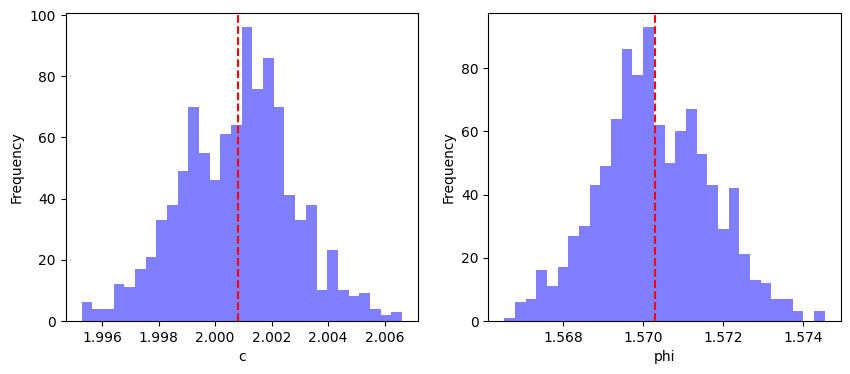

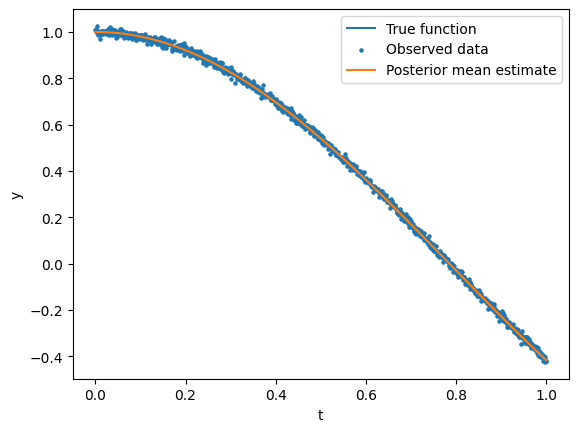

In [96]:
import matplotlib.pyplot as plt

# Get the posterior samples of c and phi
c_samples = mcmc.get_samples()["c"].detach().numpy()
phi_samples = mcmc.get_samples()["phi"].detach().numpy()

# Plot the histograms of the posterior samples
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(c_samples, bins=30, color="blue", alpha=0.5)
axs[0].axvline(np.mean(c_samples), color="red", linestyle="--", label="Estimated parameter")
axs[0].set_xlabel("c")
axs[0].set_ylabel("Frequency")
axs[1].hist(phi_samples, bins=30, color="blue", alpha=0.5)
axs[1].axvline(np.mean(phi_samples), color="red", linestyle="--", label="Estimated parameter")
axs[1].set_xlabel("phi")
axs[1].set_ylabel("Frequency")
plt.show()

# Plot the true function and the observed data
plt.figure()
plt.plot(t, y_true, label="True function")
plt.scatter(t, y_obs, s=5, label="Observed data")

# Plot the posterior mean estimate of the function
c_posterior_mean = mcmc.get_samples()["c"].mean().item()
phi_posterior_mean = mcmc.get_samples()["phi"].mean().item()
y_posterior_mean = torch.sin(c_posterior_mean * t + phi_posterior_mean)
plt.plot(t, y_posterior_mean, label="Posterior mean estimate")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

**One dimensional Heat Equation**

In [38]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

# Define the heat equation
def heat(D, u0, q, tdim):
    xdim = len(u0)
    Z = torch.zeros((tdim, xdim))
    Z[0, :] = u0
    for tin in range(1, tdim):
        tip = tin - 1
        Z[tin, 1:-1] = Z[tip, 1:-1] + D * q * (Z[tip, :-2] - 2 * Z[tip, 1:-1] + Z[tip, 2:])
    return Z

# Problem parameters
L = 10
D = 0.5
s = 0.03
Tmax = 2
xdim = 25
tdim = 75

# Discretization
x = torch.linspace(0, L, xdim)
t = torch.linspace(0, Tmax, tdim)
dx = x[1] - x[0]
dt = t[1] - t[0]
q = dt / dx ** 2
r1 = 0.75 * L
r2 = 0.8 * L

# Initial condition
u0 = torch.zeros(xdim)
u0[(x >= r1) & (x <= r2)] = 1
xDat = torch.arange(1, xdim - 1)
tDat = torch.tensor([tdim - 1])
nxDat = len(xDat)
ntDat = len(tDat)

# Solve the heat equation
Z = heat(D, u0, q, tdim)
u = Z[tDat, xDat]
uDat = u + s * torch.randn(ntDat, nxDat)

# Define the Pyro model
def model(uDat):
    XD = pyro.sample("XD", dist.Normal(torch.tensor([1.0]), torch.tensor([1.0])))
    Z = heat(D=XD, u0=u0, q=q, tdim=tdim)
    u = Z[tDat, xDat]
    pyro.sample("obs", dist.Normal(u, s), obs=uDat)

# Define the Pyro MCMC kernel
kernel = NUTS(model)

# Run the MCMC algorithm
pyro.set_rng_seed(0)
mcmc = MCMC(kernel, num_samples=1000, warmup_steps=100, num_chains=1)
mcmc.run(uDat)

# Print the posterior mean and standard deviation of XD
posterior_samples = mcmc.get_samples()["XD"]
print("Posterior mean of XD: ", posterior_samples.mean().item())
print("Posterior standard deviation of XD: ", posterior_samples.std().item())

Sample: 100%|██████████| 1100/1100 [01:46, 10.28it/s, step size=1.68e-01, acc. prob=0.917]

Posterior mean of XD:  0.5201306939125061
Posterior standard deviation of XD:  0.0651797205209732


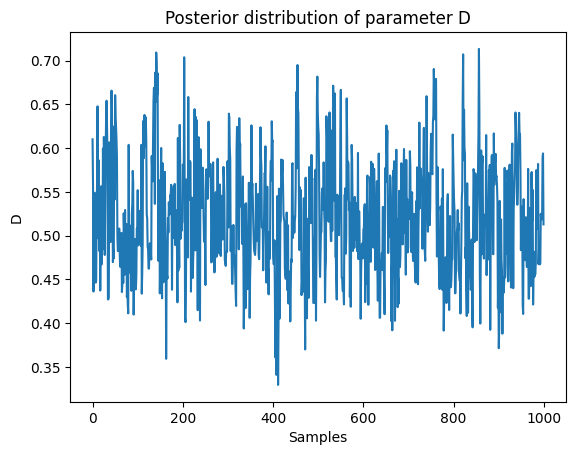

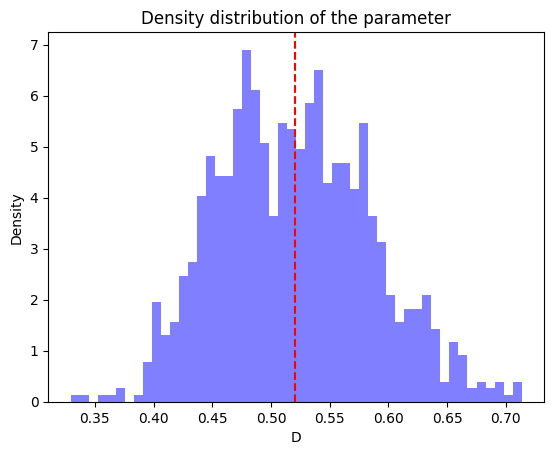

In [39]:
import matplotlib.pyplot as plt

# Plot posterior distribution of parameter D
plt.figure()
plt.plot(posterior_samples)
plt.xlabel('Samples')
plt.ylabel('D')
plt.title('Posterior distribution of parameter D')
plt.show()

plt.figure()
plt.hist(posterior_samples.numpy(), bins=50, density=True, color="blue", alpha=0.5)
plt.axvline(np.mean(posterior_samples.numpy()), color="red", linestyle="--", label="Estimated parameter")
plt.xlabel("D")
plt.ylabel("Density")
plt.title("Density distribution of the parameter")
plt.show()

**Lorenz Equations**

#####The model is a system of three ordinary differential equations now known as the Lorenz equations:
\begin{align}
  \frac{dx}{dt} = σ (y-x) \\[1em]
    \frac{dy}{dt} = x(\rho - z)-y \\[1em]
      \frac{dz}{dt} = xy-βz
    \end{align}
When $σ = 10$, $ρ = 28$, and $β = 8/3$, the Lorenz system has chaotic solutions (but not all solutions are chaotic).

In [88]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

# Define the Lorenz equations
def lorenz(x, y, z, s=10, r=28, b=8/3):
    dx = s * (y - x)
    dy = r * x - y - x * z
    dz = x * y - b * z
    return dx, dy, dz

# Define the Pyro model
def model(data):
    # Initialize parameters
    x = torch.tensor([0.0])
    y = torch.tensor([1.0])
    z = torch.tensor([1.05])
    sigma = pyro.sample("sigma", dist.Normal(10.0, 1.0))
    rho = pyro.sample("rho", dist.Normal(28.0, 1.0))
    beta = pyro.sample("beta", dist.Normal(2.6667, 0.1))

    # Run the Lorenz equations forward
    for i in range(len(data)):
        dx, dy, dz = lorenz(x, y, z, s=sigma, r=rho, b=beta)
        x = x + dx * 0.01
        y = y + dy * 0.01
        z = z + dz * 0.01

    # Compare the final state to the observed data
    pyro.sample("obs", dist.Normal(torch.tensor([x, y, z]), 0.1), obs=data)

# Problem parameters
data = torch.tensor([0.0, 1.0, 1.05])

# Define the Pyro MCMC kernel
kernel = NUTS(model)

mcmc = MCMC(kernel, num_samples=1000, warmup_steps=100, num_chains=1)

# Run the MCMC algorithm
pyro.set_rng_seed(0)
mcmc.run(data)

# Print the posterior mean and standard deviation of sigma, rho, and beta
posterior_samples = mcmc.get_samples()
print("Posterior mean of sigma: ", posterior_samples["sigma"].mean().item())
print("Posterior standard deviation of sigma: ", posterior_samples["sigma"].std().item())
print("Posterior mean of rho: ", posterior_samples["rho"].mean().item())
print("Posterior standard deviation of rho: ", posterior_samples["rho"].std().item())
print("Posterior mean of beta: ", posterior_samples["beta"].mean().item())
print("Posterior standard deviation of beta: ", posterior_samples["beta"].std().item())

Sample: 100%|██████████| 1100/1100 [03:31,  5.19it/s, step size=2.36e-02, acc. prob=0.780]

Posterior mean of sigma:  9.345343589782715
Posterior standard deviation of sigma:  0.9371585249900818
Posterior mean of rho:  28.043344497680664
Posterior standard deviation of rho:  0.9859517216682434
Posterior mean of beta:  2.66418194770813
Posterior standard deviation of beta:  0.10280443727970123


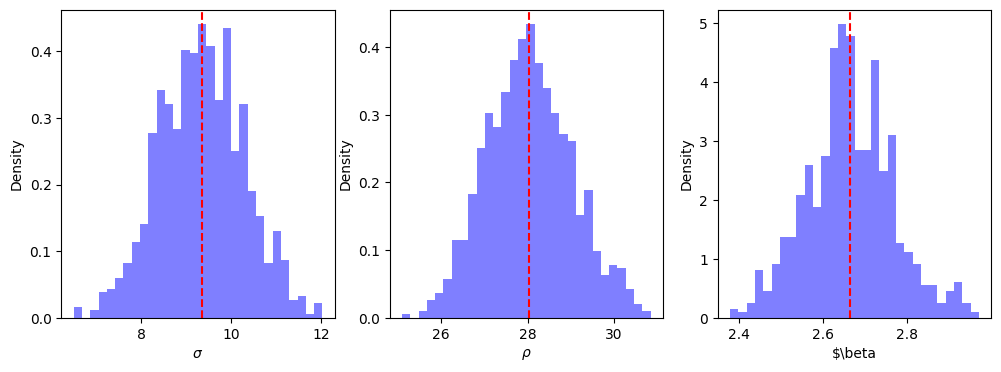

In [108]:
import matplotlib.pyplot as plt

# Plot posterior distributions of sigma, rho, and beta
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axs[0].hist(posterior_samples["sigma"].cpu().numpy(), bins=30, density=True, color="blue", alpha=0.5)
axs[0].axvline(np.mean(posterior_samples["sigma"].cpu().numpy()), color="red", linestyle="--", label="Estimated parameter")
axs[0].set_xlabel(r'$\sigma$')
axs[0].set_ylabel("Density")
axs[1].hist(posterior_samples["rho"].cpu().numpy(), bins=30, density=True, color="blue", alpha=0.5)
axs[1].axvline(np.mean(posterior_samples["rho"].cpu().numpy()), color="red", linestyle="--", label="Estimated parameter")
axs[1].set_xlabel(r'$\rho$')
axs[1].set_ylabel("Density")
axs[2].hist(posterior_samples["beta"].cpu().numpy(), bins=30, density=True, color="blue", alpha=0.5)
axs[2].axvline(np.mean(posterior_samples["beta"].cpu().numpy()), color="red", linestyle="--", label="Estimated parameter")
axs[2].set_xlabel(r'$\beta')
axs[2].set_ylabel("Density")
plt.show()